<a href="https://colab.research.google.com/github/nye0/SAM-Med2D/blob/main/predictor_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Set-up
edit from [sam colab](https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb#scrollTo=MTeAdX_mHwAR)



If you're running this notebook locally using Jupyter, please clone `SAM-Med2D` into a directory named `SAM_Med2D`. Note that you do **not** need to install `segment_anything` in your local environment, as `SAM-Med2D` and `SAM` share function names that could lead to conflicts.

For Google Colab users: Set `using_colab=True` in the cell below before executing it. Although you can select 'GPU' under 'Edit' -> 'Notebook Settings' -> 'Hardware Accelerator', this notebook is designed to run efficiently in a CPU environment as well.



# SAM-Med2D generates predicted object masks based on prompts.

In [1]:
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import torch
import torch.nn.functional as F
from skimage.measure import label, regionprops

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.array([0, 1, 0, 0.5])
    else:
        color = np.array([1, 0, 0, 0.5])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker=".",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker=".",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=1)
    )

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load SAM-Med2D model

In [4]:
from argparse import Namespace

from segment_anything import sam_model_registry
from segment_anything.predictor_sammed import SammedPredictor

In [5]:
args = Namespace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.image_size = 256
args.encoder_adapter = True
args.sam_checkpoint = "/volume/willy-dev/sota/SAM-Med2D/sam-med2d_b.pth"
model = sam_model_registry["vit_b"](args).to(device)
predictor = SammedPredictor(model)

True
*******load /volume/willy-dev/sota/SAM-Med2D/sam-med2d_b.pth


In [6]:
args = Namespace()
args.image_size = 1024
args.encoder_adapter = False
args.sam_checkpoint = "/volume/willy-dev/sota/SAM-Med2D/sam_vit_b_01ec64.pth"
model2 = sam_model_registry["vit_b"](args).to(device)
predictor2 = SammedPredictor(model2)

*******load /volume/willy-dev/sota/SAM-Med2D/sam_vit_b_01ec64.pth


In [7]:
import hydra
from cutie.inference.inference_core import InferenceCore
from cutie.inference.utils.args_utils import get_dataset_cfg
from cutie.model.cutie import CUTIE
from gui.interactive_utils import (
    image_to_torch,
    index_numpy_to_one_hot_torch,
    overlay_davis,
    torch_prob_to_numpy_mask,
)
from hydra import compose, initialize
from omegaconf import open_dict

hydra.core.global_hydra.GlobalHydra.instance().clear()

with torch.inference_mode():
    initialize(
        version_base="1.3.2", config_path="Cutie/cutie/config", job_name="eval_config"
    )
    cfg = compose(config_name="eval_config")

    with open_dict(cfg):
        cfg["weights"] = (
            "/volume/willy-dev/sota/SAM-Med2D/Cutie/weights/cutie-base-mega.pth"
        )

    data_cfg = get_dataset_cfg(cfg)

    # Load the network weights
    cutie = CUTIE(cfg).cuda().eval()
    model_weights = torch.load(cfg.weights)
    cutie.load_weights(model_weights)

processor = InferenceCore(cutie, cfg=cfg)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 73.2MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 69.2MB/s]


In [8]:
import glob
import os

from tqdm import tqdm

In [9]:
def norm_volume(img):
    img = img.astype(float)
    img -= img.min()
    img /= img.max()
    img *= 255
    img = img.astype(int)
    return img


def get_slice(img, mask, index):

    slce = img[index]
    slce = np.stack([slce, slce, slce], axis=2)

    gt = mask[index]

    return np.copy(slce), np.copy(gt)


def get_predict(img, predictor, point=None, box=None):

    predictor.set_image(slce)

    if point is not None:
        input_point = np.array([point])
        input_label = np.array([1])
    else:
        input_point, input_label = None, None

    if box is not None:
        box = np.array([box])
    else:
        box = None

    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        box=box,
        multimask_output=True,
    )

    return masks[0]

    return predictor.model.image_encoder(x).flatten().unsqueeze(0)

In [10]:
def visualize(slce, predict_mask, gt, box, fn):
    plt.figure(figsize=(5, 5))
    plt.imshow(slce)
    show_mask(gt, plt.gca(), random_color=True)
    show_mask(predict_mask, plt.gca())
    show_box(box, plt.gca())
    plt.axis("off")
    plt.show()
    # plt.savefig(f"output/{fn}")

In [11]:
# def visualize(slce, predict_mask, gt, points, labels, fn):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(slce)
#     # show_mask(gt, plt.gca(), random_color=True)
#     show_mask(predict_mask, plt.gca())
#     show_points(points, labels, plt.gca())
#     plt.axis("off")
#     # plt.show()
#     plt.savefig(f"output/{fn}")

In [12]:
def pad_box(box, pad):
    h, w = box[3] - box[1], box[2] - box[0]
    y, x = (box[3] + box[1]) / 2, (box[2] + box[0]) / 2
    box = np.array([y - h / 2 * pad, x - w / 2 * pad, y + h / 2 * pad, x + w / 2 * pad])
    return box

In [13]:
dis = glob.glob("/volume/open-dataset-ssd/ai99/gen_data/meningioma/*")

In [14]:
img = sitk.ReadImage(f"{dis[0]}/axc.nii.gz")

In [15]:
def vos_step(processor, slce):
    frame_torch = image_to_torch(slce, device=device)
    frame_torch = F.interpolate(frame_torch.unsqueeze(0), (480, 480), mode="bilinear")
    frame_torch = frame_torch[0]

    with torch.inference_mode():
        prediction, logits = processor.step(frame_torch, end=True)

    prediction = torch_prob_to_numpy_mask(prediction)

    prediction = torch.tensor(prediction).float().unsqueeze(0).unsqueeze(0)
    prediction = F.interpolate(prediction, (gt.shape[0], gt.shape[1]))[0][0]

    return frame_torch, prediction, logits


def sam_step(predictor, slce, logits, box):

    mask_logits = F.interpolate(logits[:, [1]], (64, 64), mode="bilinear")

    predictor.set_image(slce.astype(np.float32))
    masks, scores, logits = predictor.predict(
        box=box,
        multimask_output=True,
        mask_input=mask_logits[:, 0].cpu().numpy(),
    )

    return masks


def vos_reset(processor, frame_torch, masks):
    mask_torch = torch.zeros(4, 480, 480).cuda()
    masks = F.interpolate(torch.tensor(masks).cuda().unsqueeze(0), (480, 480))[0]
    mask_torch[0] = masks[0]

    with torch.inference_mode():
        processor.clear_memory()
        processor.step(frame_torch, mask_torch, idx_mask=False)

In [16]:
fns = os.listdir("/volume/open-dataset-nas/AMOS/amos22/imagesTr")
import torch.nn.functional as F

In [26]:
dices = []
dicesb = []

In [27]:
from torchvision import ops

with torch.inference_mode():
    # for di in tqdm(dis):

    #     try:
    #         nii_img = sitk.ReadImage(f"{di}/axc.nii.gz")
    #         nii_img = sitk.GetArrayFromImage(nii_img)

    #         nii_mask = sitk.ReadImage(f"{di}/seg.nii.gz")
    #         nii_mask = sitk.GetArrayFromImage(nii_mask)
    #     except:
    #         continue
    for fn in tqdm(fns):

        if ".nii.gz" not in fn:
            continue

        nii_img = sitk.ReadImage(f"/volume/open-dataset-nas/AMOS/amos22/imagesTr/{fn}")
        nii_img = sitk.GetArrayFromImage(nii_img)

        nii_mask = sitk.ReadImage(f"/volume/open-dataset-nas/AMOS/amos22/labelsTr/{fn}")
        nii_mask = sitk.GetArrayFromImage(nii_mask)

        nii_mask = nii_mask.astype(int)
        nii_mask[nii_mask != 2] = 0
        nii_mask[nii_mask == 2] = 1

        nii_img = np.clip(nii_img, -350, 450)

        # nii_mask = label(nii_mask)
        nii_img = norm_volume(nii_img)

        for i, prop in enumerate(regionprops(nii_mask)):

            dices_tp = 0
            dices_pred = 0

            init_center = np.array(prop.centroid).astype(int)

            if nii_img.shape[1] > 256 or nii_img.shape[2] > 256:
                la = max(init_center[1] - 128, 0)
                lb = min(init_center[1] + 128, nii_img.shape[1])
                lc = max(init_center[2] - 128, 0)
                ld = min(init_center[2] + 128, nii_img.shape[2])

                img = np.array(nii_img[:, la:lb, lc:ld])
                mask = np.array(nii_mask[:, la:lb, lc:ld])

                init_center[1] = 128
                init_center[2] = 128

                max_l = 256

                pad_h1 = (max_l - img.shape[1]) // 2
                pad_h2 = max_l - pad_h1 - img.shape[1]

                pad_w1 = (max_l - img.shape[2]) // 2
                pad_w2 = max_l - pad_w1 - img.shape[2]

                img, mask = torch.tensor(img).cuda(), torch.tensor(mask).cuda()
                img = F.pad(
                    img, (pad_w1, pad_w2, pad_h1, pad_h2, 0, 0), "constant", 0
                ).cpu().numpy()
                mask = F.pad(
                    mask, (pad_w1, pad_w2, pad_h1, pad_h2, 0, 0), "constant", 0
                ).cpu().numpy()
            else:
                img = np.array(nii_img)
                mask = np.array(nii_mask)

            z = init_center[0]
            slce, gt = get_slice(img, mask, z)

            gt[gt != (i + 1)] = 0
            gt[gt == (i + 1)] = 1

            predict_mask = gt

            frame_torch = image_to_torch(slce, device=device)
            init_frame_torch = F.interpolate(
                frame_torch.unsqueeze(0), (480, 480), mode="bilinear"
            )[0]

            mask_torch = index_numpy_to_one_hot_torch(predict_mask, 2).to(device)

            mask_torch = F.interpolate(mask_torch.unsqueeze(0), (480, 480))[0]
            init_mask_torch = torch.zeros(4, 480, 480).cuda()
            init_mask_torch[0] = mask_torch[1]

            with torch.inference_mode():
                processor.clear_memory()
                processor.step(init_frame_torch, init_mask_torch, idx_mask=False)

            temp_center_area = gt.sum()

            z = init_center[0] + 1
            while z < img.shape[0]:

                slce, gt = get_slice(img, mask, z)

                gt[gt != (i + 1)] = 0
                gt[gt == (i + 1)] = 1
                if gt.sum() == 0:
                    break

                frame_torch, prediction, logits = vos_step(processor, slce)

                regionprop = regionprops(prediction.int().cpu().numpy())

                if len(regionprop) == 0:
                    break

                box = pad_box(regionprop[0].bbox, 1.0)

                masks = sam_step(predictor, slce, logits, box)

                vos_reset(processor, frame_torch, masks)

                # visualize(slce, masks[0], gt, box, "")

                dices_tp += (gt * masks[0]).sum()
                dices_pred += masks[0].sum()
                dice_ = 2 * (gt * masks[0]).sum() / (gt.sum() + masks[0].sum() + 1e-5)
                dices.append(dice_)

                z += 1

            with torch.inference_mode():
                processor.clear_memory()
                processor.step(init_frame_torch, init_mask_torch, idx_mask=False)

            z = init_center[0] - 1
            while z >= 0:
                slce, gt = get_slice(img, mask, z)

                gt[gt != (i + 1)] = 0
                gt[gt == (i + 1)] = 1
                if gt.sum() == 0:
                    break

                frame_torch, prediction, logits = vos_step(processor, slce)

                regionprop = regionprops(prediction.int().cpu().numpy())

                if len(regionprop) == 0:
                    break

                box = pad_box(regionprop[0].bbox, 1.0)

                masks = sam_step(predictor, slce, logits, box)
                vos_reset(processor, frame_torch, masks)

                # visualize(slce, masks[0], gt, box, "")

                dices_tp += (gt * masks[0]).sum()
                dices_pred += masks[0].sum()
                dice_ = 2 * (gt * masks[0]).sum() / (gt.sum() + masks[0].sum() + 1e-5)
                dices.append(dice_)

                z -= 1

            if prop.area - temp_center_area > 0:
                dicesb_ = 2 * dices_tp / (dices_pred + prop.area - temp_center_area)
                dicesb.append(dicesb_)

                tqdm.write(f"{dicesb_} {np.mean(dices)}")

            # raise Exception

  0%|▌                                                                                                                                           | 1/241 [00:03<14:59,  3.75s/it]

0.9022270660131353 0.8810183032154475


  1%|█▏                                                                                                                                          | 2/241 [00:06<12:25,  3.12s/it]

0.8958170384507086 0.8784378277697573


  1%|█▋                                                                                                                                          | 3/241 [00:08<10:33,  2.66s/it]

0.9518363860681408 0.8942832020913439


  2%|██▎                                                                                                                                         | 4/241 [00:18<22:04,  5.59s/it]

0.7228729823160607 0.7700287990388605


  2%|██▉                                                                                                                                         | 5/241 [00:22<19:23,  4.93s/it]

0.9301561696357601 0.7831616700922961


  2%|███▍                                                                                                                                        | 6/241 [00:24<16:06,  4.11s/it]

0.9493648396553256 0.7951891720659681


  3%|████                                                                                                                                        | 7/241 [00:32<20:06,  5.15s/it]

0.4584649719615607 0.7097740156808129


  3%|████▋                                                                                                                                       | 8/241 [00:34<17:03,  4.39s/it]

0.9449625536361765 0.7262613573864173


  4%|█████▏                                                                                                                                      | 9/241 [00:38<16:12,  4.19s/it]

0.9518472320142692 0.7365227530963055


  4%|█████▊                                                                                                                                     | 10/241 [00:41<15:02,  3.91s/it]

0.9449536533581896 0.7452980223658536


  5%|██████▎                                                                                                                                    | 11/241 [00:46<15:39,  4.08s/it]

0.9135147138129025 0.7533402377795708


  5%|██████▉                                                                                                                                    | 12/241 [00:48<13:24,  3.51s/it]

0.9303716617322172 0.7612827424932532


  5%|███████▍                                                                                                                                   | 13/241 [00:51<12:28,  3.28s/it]

0.9231436126403398 0.7681813943720379


  6%|████████                                                                                                                                   | 14/241 [00:55<13:26,  3.55s/it]

0.9616617613269582 0.7760240499049849


  6%|████████▋                                                                                                                                  | 15/241 [00:59<13:46,  3.66s/it]

0.9341036923665582 0.7821875765819413


  7%|█████████▏                                                                                                                                 | 16/241 [01:01<12:21,  3.30s/it]

0.9672451193058569 0.7895040496786243


  7%|█████████▊                                                                                                                                 | 17/241 [01:04<11:40,  3.13s/it]

0.9528459110248417 0.7950730409467949


  7%|██████████▍                                                                                                                                | 18/241 [01:11<16:08,  4.34s/it]

0.9501431406803069 0.8081467636408174


  8%|██████████▉                                                                                                                                | 19/241 [01:13<12:50,  3.47s/it]

0.003780407626561473 0.8070342884912914


  8%|███████████▌                                                                                                                               | 20/241 [01:15<11:51,  3.22s/it]

0.9408143197138338 0.8116091860902734


  9%|████████████                                                                                                                               | 21/241 [01:18<10:47,  2.94s/it]

0.9473385086348313 0.81593578357978


  9%|████████████▋                                                                                                                              | 22/241 [01:21<11:14,  3.08s/it]

0.905478262947065 0.818028365595945


 10%|█████████████▎                                                                                                                             | 23/241 [01:28<15:29,  4.27s/it]

0.9533588715377745 0.8274241370680594


 10%|█████████████▊                                                                                                                             | 24/241 [01:34<16:59,  4.70s/it]

0.7875197792834828 0.8119816085164181


 10%|██████████████▍                                                                                                                            | 25/241 [01:39<17:24,  4.83s/it]

0.8342857142857143 0.8092788148941465


 11%|██████████████▉                                                                                                                            | 26/241 [01:42<15:02,  4.20s/it]

0.8966428932808904 0.8115844606473273


 11%|███████████████▌                                                                                                                           | 27/241 [01:48<17:19,  4.86s/it]

0.931760856946863 0.8177847983158498


 12%|████████████████▏                                                                                                                          | 28/241 [01:51<14:44,  4.15s/it]

0.8799491951833126 0.8192863968831776


 12%|████████████████▋                                                                                                                          | 29/241 [01:53<12:33,  3.56s/it]

0.8692553370314339 0.8203659820481883


 12%|█████████████████▎                                                                                                                         | 30/241 [01:56<12:11,  3.46s/it]

0.8828643610070563 0.8219500906577474


 13%|█████████████████▉                                                                                                                         | 31/241 [02:00<12:30,  3.57s/it]

0.9628380683202573 0.8249166517845425


 13%|██████████████████▍                                                                                                                        | 32/241 [02:04<13:00,  3.73s/it]

0.953119376124775 0.8273962028028895


 14%|███████████████████                                                                                                                        | 33/241 [02:10<15:07,  4.36s/it]

0.8691039145984846 0.8292017208111839


 14%|███████████████████▌                                                                                                                       | 34/241 [02:12<13:11,  3.82s/it]

0.9411817375965903 0.8306726934985986


 15%|████████████████████▏                                                                                                                      | 35/241 [02:15<11:55,  3.48s/it]

0.9423468302906959 0.8323927450346521


 15%|████████████████████▊                                                                                                                      | 36/241 [02:21<14:22,  4.21s/it]

0.9421602904592215 0.8372206714229044


 15%|█████████████████████▎                                                                                                                     | 37/241 [02:25<13:42,  4.03s/it]

0.8191905930703808 0.8359591141188553


 16%|██████████████████████▍                                                                                                                    | 39/241 [02:28<10:14,  3.04s/it]

0.9321758058968185 0.8375009370358674


 17%|███████████████████████                                                                                                                    | 40/241 [02:31<09:51,  2.94s/it]

0.9501636848115721 0.839164704970162


 17%|███████████████████████▋                                                                                                                   | 41/241 [02:38<13:27,  4.04s/it]

0.911890442721542 0.8418671218891004


 17%|████████████████████████▏                                                                                                                  | 42/241 [02:41<12:14,  3.69s/it]

0.8007477599432734 0.8395475008113084


 18%|████████████████████████▊                                                                                                                  | 43/241 [02:44<11:36,  3.52s/it]

0.9612784186214549 0.841436108972656


 18%|█████████████████████████▍                                                                                                                 | 44/241 [02:47<11:24,  3.47s/it]

0.9251158027266492 0.8431236886243654


 19%|█████████████████████████▉                                                                                                                 | 45/241 [02:51<11:42,  3.59s/it]

0.9445635528330781 0.844396179969443


 19%|██████████████████████████▌                                                                                                                | 46/241 [02:57<14:02,  4.32s/it]

0.9004786528706848 0.8461726915365876


 20%|███████████████████████████                                                                                                                | 47/241 [03:01<13:47,  4.27s/it]

0.9412598623412586 0.846942612135089


 20%|███████████████████████████▋                                                                                                               | 48/241 [03:12<20:07,  6.26s/it]

0.9098848831420737 0.851271073538318


 20%|████████████████████████████▎                                                                                                              | 49/241 [03:16<17:38,  5.52s/it]

0.8526446840400329 0.850699726144356


 21%|████████████████████████████▊                                                                                                              | 50/241 [03:19<14:33,  4.57s/it]

0.9533983276368727 0.8517959365311863


 21%|█████████████████████████████▍                                                                                                             | 51/241 [03:21<12:20,  3.90s/it]

0.941819337075082 0.8527015576459176


 22%|█████████████████████████████▉                                                                                                             | 52/241 [03:25<12:48,  4.06s/it]

0.9387319135816063 0.853527196130276


 22%|██████████████████████████████▌                                                                                                            | 53/241 [03:31<13:59,  4.47s/it]

0.869417058843736 0.853119733469146


 22%|███████████████████████████████▏                                                                                                           | 54/241 [03:33<11:47,  3.78s/it]

0.88631719731025 0.853481514373274


 23%|███████████████████████████████▋                                                                                                           | 55/241 [03:36<11:32,  3.73s/it]

0.8170278999182847 0.8529600047191203


 23%|████████████████████████████████▎                                                                                                          | 56/241 [03:38<09:42,  3.15s/it]

0.9314725304649738 0.8533657440930331


 24%|████████████████████████████████▉                                                                                                          | 57/241 [03:43<10:51,  3.54s/it]

0.9382955846137838 0.8544838738037098


 24%|█████████████████████████████████▍                                                                                                         | 58/241 [03:45<09:48,  3.21s/it]

0.8670805794779358 0.8545877063317788


 24%|██████████████████████████████████                                                                                                         | 59/241 [03:52<13:20,  4.40s/it]

0.9005387327933415 0.8559396963628462


 25%|██████████████████████████████████▌                                                                                                        | 60/241 [03:55<11:58,  3.97s/it]

0.9549931272777715 0.8564614722540148


 25%|███████████████████████████████████▏                                                                                                       | 61/241 [03:59<12:00,  4.00s/it]

0.9570585510282181 0.8574984269309512


 26%|███████████████████████████████████▊                                                                                                       | 62/241 [04:03<11:42,  3.92s/it]

0.8884363612379838 0.8575727861037081


 26%|████████████████████████████████████▎                                                                                                      | 63/241 [04:06<10:16,  3.46s/it]

0.7679403886968369 0.8572745250474325


 27%|████████████████████████████████████▉                                                                                                      | 64/241 [04:08<09:20,  3.17s/it]

0.9416441644164416 0.8578577200643418


 27%|█████████████████████████████████████▍                                                                                                     | 65/241 [04:12<09:45,  3.33s/it]

0.8847543861295986 0.8580387380902573


 27%|██████████████████████████████████████                                                                                                     | 66/241 [04:15<09:19,  3.20s/it]

0.8946809921740284 0.8580208465410529


 28%|██████████████████████████████████████▋                                                                                                    | 67/241 [04:23<13:56,  4.81s/it]

0.8601156377394688 0.8575380173307047


 28%|███████████████████████████████████████▏                                                                                                   | 68/241 [04:27<13:18,  4.62s/it]

0.9589910732613387 0.8585253892731469


 29%|███████████████████████████████████████▊                                                                                                   | 69/241 [04:31<12:02,  4.20s/it]

0.9571131065866055 0.8593494179582515


 29%|████████████████████████████████████████▎                                                                                                  | 70/241 [04:42<17:58,  6.31s/it]

0.9173797516279613 0.8612404235094865


 29%|████████████████████████████████████████▉                                                                                                  | 71/241 [04:44<14:49,  5.23s/it]

0.9379066069105103 0.8614716226408002


 30%|█████████████████████████████████████████▌                                                                                                 | 72/241 [04:51<15:38,  5.56s/it]

0.9459447538876428 0.8631864099612722


 30%|██████████████████████████████████████████                                                                                                 | 73/241 [04:54<13:20,  4.76s/it]

0.93773879352096 0.8638229680090809


 31%|██████████████████████████████████████████▋                                                                                                | 74/241 [05:02<16:12,  5.82s/it]

0.9126344873371995 0.8640508905985004


 31%|███████████████████████████████████████████▎                                                                                               | 75/241 [05:05<13:41,  4.95s/it]

0.9771779141104294 0.8650101428243815


 32%|███████████████████████████████████████████▊                                                                                               | 76/241 [05:08<11:45,  4.28s/it]

0.8206105510632993 0.8635159118376414


 32%|████████████████████████████████████████████▍                                                                                              | 77/241 [05:10<10:22,  3.80s/it]

0.9214019177176326 0.8638950708691265


 32%|████████████████████████████████████████████▉                                                                                              | 78/241 [05:17<12:46,  4.70s/it]

0.9528319532434496 0.8655927494989636


 33%|█████████████████████████████████████████████▌                                                                                             | 79/241 [05:19<10:46,  3.99s/it]

0.9588219047379918 0.8661858252790018


 33%|██████████████████████████████████████████████▏                                                                                            | 80/241 [05:23<10:12,  3.81s/it]

0.9286339272404384 0.8666194394361206


 34%|██████████████████████████████████████████████▋                                                                                            | 81/241 [05:27<10:17,  3.86s/it]

0.9169981935699444 0.866875328143216


 34%|███████████████████████████████████████████████▎                                                                                           | 82/241 [05:29<08:59,  3.39s/it]

0.9582295988934993 0.8673927755249502


 34%|███████████████████████████████████████████████▊                                                                                           | 83/241 [05:34<10:03,  3.82s/it]

0.9462678053479274 0.8678803357673016


 35%|████████████████████████████████████████████████▍                                                                                          | 84/241 [05:36<08:49,  3.37s/it]

0.9303997659091225 0.8681754342963843


 35%|█████████████████████████████████████████████████                                                                                          | 85/241 [05:39<08:19,  3.20s/it]

0.9499298336444268 0.8686892199058204


 36%|█████████████████████████████████████████████████▌                                                                                         | 86/241 [05:41<07:23,  2.86s/it]

0.9154094827586207 0.8689169754098279


 36%|██████████████████████████████████████████████████▏                                                                                        | 87/241 [05:47<09:39,  3.76s/it]

0.7712388226813295 0.8652177146319727


 37%|██████████████████████████████████████████████████▊                                                                                        | 88/241 [05:51<09:50,  3.86s/it]

0.9472373397288073 0.8656781587231523


 37%|███████████████████████████████████████████████████▎                                                                                       | 89/241 [06:02<15:00,  5.93s/it]

0.8913529155983386 0.8660597409259893


 37%|███████████████████████████████████████████████████▉                                                                                       | 90/241 [06:05<12:59,  5.16s/it]

0.9328653183956545 0.8662529776115534


 38%|████████████████████████████████████████████████████▍                                                                                      | 91/241 [06:09<11:52,  4.75s/it]

0.9402912304544285 0.8665811151185266


 38%|█████████████████████████████████████████████████████                                                                                      | 92/241 [06:13<11:01,  4.44s/it]

0.9207471371884877 0.8667822819603352


 39%|█████████████████████████████████████████████████████▋                                                                                     | 93/241 [06:15<09:24,  3.82s/it]

0.9482467282749298 0.8671810582535355


 39%|██████████████████████████████████████████████████████▏                                                                                    | 94/241 [06:18<08:42,  3.56s/it]

0.9218359917569199 0.8674986154873948


 39%|██████████████████████████████████████████████████████▊                                                                                    | 95/241 [06:22<08:44,  3.59s/it]

0.9410762438677491 0.8680156697181296


 40%|███████████████████████████████████████████████████████▎                                                                                   | 96/241 [06:25<08:49,  3.65s/it]

0.9214248576875391 0.8681086264041301


 40%|███████████████████████████████████████████████████████▉                                                                                   | 97/241 [06:29<08:34,  3.57s/it]

0.9553424291461912 0.8686124033212763


 41%|████████████████████████████████████████████████████████▌                                                                                  | 98/241 [06:31<07:46,  3.26s/it]

0.9636072913335465 0.8691231837013478


 41%|█████████████████████████████████████████████████████████                                                                                  | 99/241 [06:36<08:49,  3.73s/it]

0.9194820506565842 0.8695097851016179


 41%|█████████████████████████████████████████████████████████▎                                                                                | 100/241 [06:39<07:58,  3.39s/it]

0.9382453999124425 0.8698812606241373


 42%|█████████████████████████████████████████████████████████▊                                                                                | 101/241 [06:42<07:51,  3.37s/it]

0.9096582390404552 0.8697534592325975


 42%|██████████████████████████████████████████████████████████▍                                                                               | 102/241 [06:45<07:34,  3.27s/it]

0.9568916141639433 0.8701525665409807


 43%|██████████████████████████████████████████████████████████▉                                                                               | 103/241 [06:49<07:46,  3.38s/it]

0.9325422131033909 0.8705151854852813


 43%|███████████████████████████████████████████████████████████▌                                                                              | 104/241 [06:51<07:08,  3.13s/it]

0.921786724801707 0.8708475459757303


 44%|████████████████████████████████████████████████████████████                                                                              | 105/241 [06:54<06:28,  2.86s/it]

0.9490311995769549 0.8712648864341914


 44%|████████████████████████████████████████████████████████████▋                                                                             | 106/241 [06:57<07:00,  3.11s/it]

0.8891853201457575 0.8711820457865019


 44%|█████████████████████████████████████████████████████████████▎                                                                            | 107/241 [07:00<06:30,  2.91s/it]

0.9476908372072815 0.871568743037917


 45%|█████████████████████████████████████████████████████████████▊                                                                            | 108/241 [07:10<11:36,  5.24s/it]

0.876110621563278 0.8705145724231024


 45%|██████████████████████████████████████████████████████████████▍                                                                           | 109/241 [07:14<10:11,  4.63s/it]

0.8304404844557587 0.8701672320881219


 46%|██████████████████████████████████████████████████████████████▉                                                                           | 110/241 [07:18<09:43,  4.45s/it]

0.9578523312640338 0.87052344176763


 46%|███████████████████████████████████████████████████████████████▌                                                                          | 111/241 [07:20<08:19,  3.84s/it]

0.9259255080280275 0.870762597530171


 46%|████████████████████████████████████████████████████████████████▏                                                                         | 112/241 [07:22<07:11,  3.34s/it]

0.7756790982217704 0.8695328594843105


 47%|████████████████████████████████████████████████████████████████▋                                                                         | 113/241 [07:29<09:15,  4.34s/it]

0.7508999034803838 0.8642527029704453


 47%|█████████████████████████████████████████████████████████████████▎                                                                        | 114/241 [07:31<07:49,  3.69s/it]

0.9432757593805837 0.8646321574491946


 48%|█████████████████████████████████████████████████████████████████▊                                                                        | 115/241 [07:41<11:37,  5.53s/it]

0.7500307711854649 0.8592730453077015


 48%|██████████████████████████████████████████████████████████████████▍                                                                       | 116/241 [07:49<13:17,  6.38s/it]

0.9152120455745767 0.8599454814821532


 49%|██████████████████████████████████████████████████████████████████▉                                                                       | 117/241 [07:52<10:41,  5.17s/it]

0.8707162687395891 0.8597789699972229


 49%|███████████████████████████████████████████████████████████████████▌                                                                      | 118/241 [07:54<09:02,  4.41s/it]

0.9555448175887895 0.8602074218803867


 49%|████████████████████████████████████████████████████████████████████▏                                                                     | 119/241 [07:57<08:05,  3.98s/it]

0.9579545281496032 0.8606693464521851


 50%|████████████████████████████████████████████████████████████████████▋                                                                     | 120/241 [08:02<08:28,  4.20s/it]

0.9610484143841361 0.8612380743093451


 50%|█████████████████████████████████████████████████████████████████████▎                                                                    | 121/241 [08:08<09:27,  4.73s/it]

0.8957231597564057 0.861267892725386


 51%|█████████████████████████████████████████████████████████████████████▊                                                                    | 122/241 [08:13<09:44,  4.92s/it]

0.9015509279885109 0.861569995988685


 51%|██████████████████████████████████████████████████████████████████████▍                                                                   | 123/241 [08:16<08:13,  4.18s/it]

0.9524401045604788 0.8620155844504633


 51%|███████████████████████████████████████████████████████████████████████                                                                   | 124/241 [08:19<07:50,  4.02s/it]

0.9182739289204341 0.8622029791150141


 52%|███████████████████████████████████████████████████████████████████████▌                                                                  | 125/241 [08:23<07:39,  3.96s/it]

0.950944782699979 0.8625660844255466


 52%|████████████████████████████████████████████████████████████████████████▏                                                                 | 126/241 [08:27<07:28,  3.90s/it]

0.9456581761617733 0.8628547540987359


 53%|████████████████████████████████████████████████████████████████████████▋                                                                 | 127/241 [08:34<08:57,  4.71s/it]

0.9383931068465421 0.8637907034846072


 53%|█████████████████████████████████████████████████████████████████████████▎                                                                | 128/241 [08:39<09:16,  4.93s/it]

0.9475193910104165 0.8646697124127712


 54%|█████████████████████████████████████████████████████████████████████████▊                                                                | 129/241 [08:41<07:17,  3.91s/it]

0.27613500597371565 0.8630598680339261


 54%|██████████████████████████████████████████████████████████████████████████▍                                                               | 130/241 [08:44<06:49,  3.69s/it]

0.8980129155307702 0.8632238414588096


 54%|███████████████████████████████████████████████████████████████████████████                                                               | 131/241 [08:50<08:16,  4.51s/it]

0.928493436682585 0.8639117781347717


 55%|███████████████████████████████████████████████████████████████████████████▌                                                              | 132/241 [08:57<09:37,  5.29s/it]

0.9457039001866588 0.8647325496451763


 55%|████████████████████████████████████████████████████████████████████████████▏                                                             | 133/241 [09:04<10:30,  5.84s/it]

0.9367385860892354 0.8654628540590649


 56%|████████████████████████████████████████████████████████████████████████████▋                                                             | 134/241 [09:11<10:51,  6.09s/it]

0.9550424416280655 0.8662585460776041


 56%|█████████████████████████████████████████████████████████████████████████████▎                                                            | 135/241 [09:14<09:02,  5.12s/it]

0.9659315784228585 0.866665809525838


 56%|█████████████████████████████████████████████████████████████████████████████▉                                                            | 136/241 [09:18<08:17,  4.73s/it]

0.9375712106590294 0.8669143257077941


 57%|██████████████████████████████████████████████████████████████████████████████▍                                                           | 137/241 [09:20<06:53,  3.97s/it]

0.9200434793599434 0.8670597389638192


 57%|███████████████████████████████████████████████████████████████████████████████                                                           | 138/241 [09:22<05:59,  3.49s/it]

0.9375281912494362 0.8673042449588472


 58%|███████████████████████████████████████████████████████████████████████████████▌                                                          | 139/241 [09:25<05:38,  3.32s/it]

0.9472064393939394 0.8674593819128389


 58%|████████████████████████████████████████████████████████████████████████████████▏                                                         | 140/241 [09:28<05:05,  3.02s/it]

0.9430601531877173 0.867746229995786


 59%|████████████████████████████████████████████████████████████████████████████████▋                                                         | 141/241 [09:31<05:02,  3.03s/it]

0.955297729039815 0.8680955070397767


 59%|█████████████████████████████████████████████████████████████████████████████████▎                                                        | 142/241 [09:34<05:14,  3.17s/it]

0.9571593043689026 0.8685140444115904


 59%|█████████████████████████████████████████████████████████████████████████████████▉                                                        | 143/241 [09:37<04:56,  3.03s/it]

0.9460628431783557 0.8687880917355759


 60%|██████████████████████████████████████████████████████████████████████████████████▍                                                       | 144/241 [09:43<06:20,  3.92s/it]

0.8287447714511814 0.868369995201269


 60%|███████████████████████████████████████████████████████████████████████████████████                                                       | 145/241 [09:46<05:44,  3.58s/it]

0.8470888036675702 0.8679838232848905


 61%|███████████████████████████████████████████████████████████████████████████████████▌                                                      | 146/241 [09:54<07:43,  4.88s/it]

0.7686981436160688 0.8643830897470002


 61%|████████████████████████████████████████████████████████████████████████████████████▏                                                     | 147/241 [09:56<06:43,  4.29s/it]

0.9416765160469134 0.864712555003952


 61%|████████████████████████████████████████████████████████████████████████████████████▋                                                     | 148/241 [10:00<06:19,  4.08s/it]

0.9594566382273936 0.8650351681600205


 62%|█████████████████████████████████████████████████████████████████████████████████████▎                                                    | 149/241 [10:06<07:02,  4.60s/it]

0.741872106792981 0.8624625432286493


 62%|█████████████████████████████████████████████████████████████████████████████████████▉                                                    | 150/241 [10:08<05:56,  3.91s/it]

0.9508963850194462 0.8627552910706203


 63%|██████████████████████████████████████████████████████████████████████████████████████▍                                                   | 151/241 [10:12<05:45,  3.84s/it]

0.9628224293984942 0.8630215230555667


 63%|███████████████████████████████████████████████████████████████████████████████████████                                                   | 152/241 [10:15<05:13,  3.52s/it]

0.8878919712978134 0.8631510302278197


 63%|███████████████████████████████████████████████████████████████████████████████████████▌                                                  | 153/241 [10:18<05:16,  3.60s/it]

0.886141465553559 0.8630852363057766


 64%|████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 154/241 [10:22<05:06,  3.52s/it]

0.8970627384861124 0.8632021401327944


 64%|████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 155/241 [10:24<04:28,  3.12s/it]

0.9460326363206142 0.8634475150123554


 65%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                | 156/241 [10:26<04:09,  2.93s/it]

0.9549093199653552 0.8637493547490941


 65%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                | 157/241 [10:29<04:03,  2.89s/it]

0.9422886033675031 0.8640685356002519


 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                               | 158/241 [10:31<03:35,  2.60s/it]

0.9180502635579334 0.864198666775435


 66%|███████████████████████████████████████████████████████████████████████████████████████████                                               | 159/241 [10:35<03:59,  2.93s/it]

0.9376523412443875 0.864455641467969


 66%|███████████████████████████████████████████████████████████████████████████████████████████▌                                              | 160/241 [10:37<03:50,  2.85s/it]

0.9109114729552685 0.8645762577344607


 67%|████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 161/241 [10:40<03:45,  2.82s/it]

0.9432643073063398 0.864823142743169


 67%|████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 162/241 [10:42<03:27,  2.62s/it]

0.8677569881755991 0.864573053146245


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 163/241 [10:47<04:01,  3.10s/it]

0.8955613577023499 0.8646249146870887


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 164/241 [10:51<04:22,  3.40s/it]

0.9597263722057174 0.8649930902427624


 68%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 165/241 [10:53<03:55,  3.09s/it]

0.9077863961813842 0.8651292926242724


 69%|███████████████████████████████████████████████████████████████████████████████████████████████                                           | 166/241 [10:56<03:41,  2.96s/it]

0.9338516023149348 0.865339844894201


 69%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 167/241 [10:59<03:42,  3.01s/it]

0.8695379104199863 0.8650965262947461


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 168/241 [11:04<04:23,  3.61s/it]

0.5922823121222269 0.8633595609299519


 70%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 169/241 [11:08<04:34,  3.82s/it]

0.9570059807152447 0.8637362009809291


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 170/241 [11:13<04:43,  3.99s/it]

0.9200256058127383 0.863941330965054


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 171/241 [11:18<05:11,  4.45s/it]

0.9495619003817942 0.8645954066587335


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 172/241 [11:21<04:36,  4.01s/it]

0.9503714901418417 0.8649481328452623


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████                                       | 173/241 [11:23<04:00,  3.54s/it]

0.9381714345411175 0.865115504347408


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 174/241 [11:34<06:13,  5.58s/it]

0.8362756445139317 0.8642181909980466


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 175/241 [11:35<04:49,  4.38s/it]

0.017000915094651656 0.8638343835662399


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 176/241 [11:39<04:29,  4.15s/it]

0.9495670883450851 0.8640652231723519


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 177/241 [11:45<05:02,  4.73s/it]

0.914133213570096 0.8644001030497209


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 178/241 [11:52<05:44,  5.47s/it]

0.9485552997103172 0.8649989853281526


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 179/241 [12:03<07:23,  7.15s/it]

0.7031078273174469 0.85883694442743


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 180/241 [12:07<06:09,  6.06s/it]

0.943785824451555 0.8589863799664991


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 181/241 [12:10<05:05,  5.09s/it]

0.9674231193218535 0.8593055288308272


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 182/241 [12:12<04:14,  4.31s/it]

0.9569913560319209 0.8595853342212483


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 183/241 [12:18<04:38,  4.81s/it]

0.7409772253901048 0.8572690052876368


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 184/241 [12:20<03:45,  3.96s/it]

0.8887316469131434 0.8573625072188906


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 185/241 [12:22<03:13,  3.46s/it]

0.948202396804261 0.8576350516497429


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 186/241 [12:25<02:48,  3.06s/it]

0.9022727272727272 0.857699753032592


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 187/241 [12:27<02:41,  2.99s/it]

0.8638914514145142 0.857517472016065


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 188/241 [12:31<02:52,  3.26s/it]

0.9242200201569891 0.8576651403368981


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 189/241 [12:34<02:43,  3.15s/it]

0.9449194670908729 0.8579040148199327


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 190/241 [12:39<03:00,  3.54s/it]

0.9397558606021043 0.8581555564676239


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 191/241 [12:41<02:38,  3.17s/it]

0.9438188787733589 0.858346395021924


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 192/241 [12:45<02:54,  3.55s/it]

0.9615717242325379 0.8586643153804189


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 193/241 [12:48<02:37,  3.28s/it]

0.945599043499666 0.858886499459478


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 194/241 [12:50<02:20,  2.99s/it]

0.9417108472447385 0.8591211219838227


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 195/241 [12:54<02:32,  3.31s/it]

0.9137349005572051 0.85932576932223


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 196/241 [12:57<02:15,  3.01s/it]

0.9658780948384389 0.8596088833492215


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 197/241 [12:59<02:00,  2.74s/it]

0.9342330673129152 0.8597827120233953


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 198/241 [13:02<02:06,  2.95s/it]

0.9532882226557676 0.8600409358714055


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 199/241 [13:09<02:52,  4.11s/it]

0.9571601948727978 0.8606323285120016


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 200/241 [13:12<02:28,  3.61s/it]

0.8982737661074641 0.8605761223862135


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 201/241 [13:17<02:48,  4.20s/it]

0.9436205205147441 0.8610802759327367


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 202/241 [13:20<02:23,  3.68s/it]

0.9383200404073626 0.8612041785212827


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 203/241 [13:26<02:56,  4.65s/it]

0.9475870585189169 0.861910010786848


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 204/241 [13:28<02:20,  3.79s/it]

0.9404448192263097 0.8620080128985674


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 205/241 [13:31<02:05,  3.49s/it]

0.9591724786458742 0.8622933537221524


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 206/241 [13:38<02:42,  4.63s/it]

0.951406497916574 0.8628178859168563


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 207/241 [13:45<02:54,  5.13s/it]

0.9596472540811019 0.8635150395691885


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 208/241 [13:51<03:06,  5.65s/it]

0.9387405671085778 0.8640652068753479


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 209/241 [13:55<02:40,  5.00s/it]

0.9544992661171955 0.8642719286902477


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 210/241 [14:02<02:51,  5.53s/it]

0.3605633142017109 0.8603721831522751


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 211/241 [14:06<02:37,  5.25s/it]

0.9493477778748514 0.8605716556223388


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 212/241 [14:17<03:17,  6.81s/it]

0.8333639569169926 0.8595916301708852


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 213/241 [14:20<02:42,  5.79s/it]

0.9218399980449817 0.8597206083109459


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 214/241 [14:23<02:11,  4.87s/it]

0.8968081354338114 0.8597655111303371


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 215/241 [14:26<01:56,  4.46s/it]

0.9687347001881071 0.8600311802142683


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 216/241 [14:29<01:34,  3.78s/it]

0.8983229480613132 0.8601316783224171


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 217/241 [14:32<01:24,  3.51s/it]

0.9515236252896899 0.8603630431507623


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 218/241 [14:35<01:19,  3.47s/it]

0.9265403215265978 0.8605217155323622


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 219/241 [14:37<01:08,  3.13s/it]

0.9532113410420486 0.8607683277641471


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 220/241 [14:40<01:03,  3.02s/it]

0.9379706466747926 0.8609546856388134


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 221/241 [14:46<01:19,  3.99s/it]

0.8420883847714391 0.8607385091036402


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 222/241 [14:49<01:06,  3.50s/it]

0.9092304664436135 0.8608521611333573


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 223/241 [14:55<01:19,  4.44s/it]

0.9509857062855808 0.8614320378545522


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 224/241 [15:01<01:20,  4.74s/it]

0.9319562188208014 0.8618318765090728


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 225/241 [15:04<01:09,  4.36s/it]

0.9065059814956685 0.8619410753163794


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 226/241 [15:11<01:14,  4.97s/it]

0.9655968259534576 0.8626102729502346


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 227/241 [15:17<01:14,  5.32s/it]

0.9493137464682944 0.8630989525227788


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 228/241 [15:20<00:59,  4.60s/it]

0.9262577695769684 0.8631768600096951


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 229/241 [15:22<00:46,  3.91s/it]

0.9309197391188606 0.8633306849762534


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 230/241 [15:25<00:39,  3.57s/it]

0.9267142073505211 0.863380502830176


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 231/241 [15:27<00:33,  3.31s/it]

0.8513839564074064 0.8633414405762773


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 232/241 [15:30<00:28,  3.13s/it]

0.9597181094807193 0.8635112832609616


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 233/241 [15:33<00:24,  3.04s/it]

0.9360838866055433 0.863437761486699


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 234/241 [15:36<00:21,  3.04s/it]

0.9634611355541588 0.8636859928519456


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 235/241 [15:39<00:18,  3.13s/it]

0.9223808077740662 0.8638115879640748


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 236/241 [15:42<00:14,  2.98s/it]

0.907381545679418 0.8639024490279799


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 237/241 [15:44<00:10,  2.69s/it]

0.9461240419695127 0.8640866703118666


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 238/241 [15:46<00:07,  2.54s/it]

0.857712946281552 0.8638468269292554


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 239/241 [15:48<00:04,  2.41s/it]

0.9398228814169487 0.8638730897530892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 240/241 [15:51<00:02,  2.59s/it]

0.9693556255266309 0.8640978559947335


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [16:00<00:00,  3.98s/it]

0.9600574487215849 0.8647107303394348


In [ ]:
np.save("tmp_dices.npy", dices)
np.save("tmp_dicesb.npy", dicesb)

In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dices = np.load("tmp_dices.npy")
dicesb = np.load("tmp_dicesb.npy")

In [29]:
dices = np.array(dices)
dicesb = np.array(dicesb)

0.8647107303394348


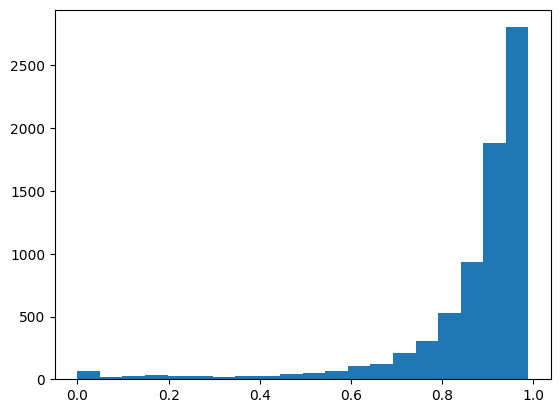

In [30]:
print(np.mean(dices))
plt.hist(dices, bins=20)
plt.show()

0.9023530316828619


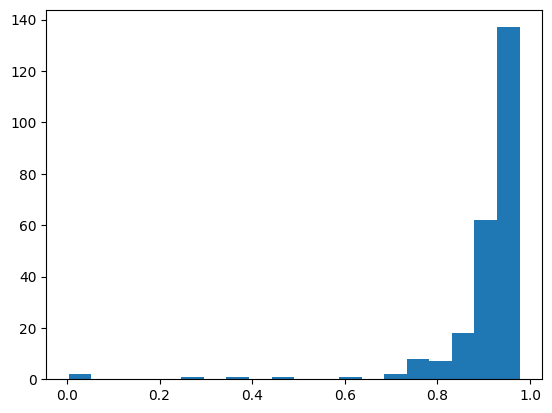

In [31]:
print(np.mean(dicesb))
plt.hist(dicesb, bins=20)
plt.show()